Objective functions can optionally take in step, budget, and generations.

step - The same objective function will be run for #evaluation_early_stop_steps, the current step will be passed into the function as an interger. (This is useful for getting a single fold of cross validation for example).

budget - A parameter that varies over the course of the generations. Gets passed into the objective function as a float between 0 and 1. If the budget of the previous evaluation is less than the current budget, it will get re-evaluated. Useful for using smaller datasets earlier in training.

generations - an int corresponding to the current generation number.


In [1]:
#knapsack problem
import numpy as np
import tpot
import random
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster

class SubsetSelector(tpot.individual.BaseIndividual):
    def __init__(   self,
                    values,
                    initial_set = None,
                    k=1, #step size for shuffling
                ):

        if isinstance(values, int):
            self.values = set(range(0,values))
        else:
            self.values = set(values)


        if initial_set is None:
            self.subsets = set(random.choices(values, k=k))
        else:
            self.subsets = set(initial_set)

        self.k = k

        self.mutation_list = [self._mutate_add, self._mutate_remove]
        self.crossover_list = [self._crossover_swap]
        

    def mutate(self, rng=None):
        mutation_list_copy = self.mutation_list.copy()
        random.shuffle(mutation_list_copy)
        for func in mutation_list_copy:
            if func():
                return True
        return False

    def crossover(self, ind2, rng=None):
        crossover_list_copy = self.crossover_list.copy()
        random.shuffle(crossover_list_copy)
        for func in crossover_list_copy:
            if func(ind2):
                return True
        return False

    def _mutate_add(self,):
        not_included = list(self.values.difference(self.subsets))
        if len(not_included) > 1:
            self.subsets.update(random.sample(not_included, k=min(self.k, len(not_included))))
            return True
        else:
            return False

    def _mutate_remove(self,):
        if len(self.subsets) > 1:
            self.subsets = self.subsets - set(random.sample(list(self.subsets), k=min(self.k, len(self.subsets)-1) ))

    def _crossover_swap(self, ss2):
        diffs = self.subsets.symmetric_difference(ss2.subsets)

        if len(diffs) == 0:
            return False
        for v in diffs:
            self.subsets.discard(v)
            ss2.subsets.discard(v)
            random.choice([self.subsets, ss2.subsets]).add(v)
        
        return True

    def unique_id(self):
        return str(tuple(sorted(self.subsets)))

def individual_generator():
    while True:
        yield SubsetSelector(values=np.arange(len(values)))


values = np.random.randint(200,size=100)
weights = np.random.random(200)*10
max_weight = 50

def simple_objective(ind, **kwargs):
    subset = np.array(list(ind.subsets))
    if len(subset) == 0:
        return 0, 0

    total_weight = np.sum(weights[subset])
    total_value = np.sum(values[subset])

    if total_weight > max_weight:
        total_value = 0

    return total_value, total_weight

objective_names = ["Value", "Weight"]
objective_function_weights = [1,-1]



evolver = tpot.evolvers.BaseEvolver(   individual_generator=individual_generator(), 
                                objective_functions=[simple_objective],
                                objective_function_weights = objective_function_weights,
                                bigger_is_better = True,
                                population_size= 100,
                                objective_names = objective_names,
                                generations= 100,
                                n_jobs=32,
                                verbose = 1,

)

evolver.optimize()

/opt/anaconda3/envs/tpotenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generation: 100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


In [2]:
final_population_results = evolver.population.evaluated_individuals
final_population_results.reset_index(inplace=True)
final_population_results = final_population_results.rename(columns = {'index':'Selected Index'})

best_idx = final_population_results["Value"].idxmax()
best_individual = final_population_results.loc[best_idx]['Individual']
print("best subset", best_individual.subsets)
print("Best value {0}, weight {1}".format(final_population_results.loc[best_idx, "Value"],final_population_results.loc[best_idx, "Weight"]))
print()

print("All results")
final_population_results

best subset {1, 8, 9, 16, 17, 22, 23, 24, 28, 29, 31, 42, 43, 48, 50, 61, 62, 68, 80, 89, 91, 97, 98}
Best value 3070.0, weight 49.01985602703945

All results


,Selected Index,Value,Weight,Parents,Variation_Function,Individual,Generation,Submitted Timestamp,Completed Timestamp,Eval Error,Pareto_Front
0,"(40,)",89.0,9.883465,NaN,NaN,<__main__.SubsetSelector object at 0x32aa80eb0>,0.0,1.740209e+09,1.740209e+09,None,NaN
1,"(45,)",116.0,6.643557,NaN,NaN,<__main__.SubsetSelector object at 0x32aa83b50>,0.0,1.740209e+09,1.740209e+09,None,NaN
2,"(52,)",172.0,9.273163,NaN,NaN,<__main__.SubsetSelector object at 0x32aa81210>,0.0,1.740209e+09,1.740209e+09,None,NaN
3,"(33,)",112.0,1.594347,NaN,NaN,<__main__.SubsetSelector object at 0x32aa838e0>,0.0,1.740209e+09,1.740209e+09,None,NaN
4,"(37,)",90.0,3.273826,NaN,NaN,<__main__.SubsetSelector object at 0x32aa83e50>,0.0,1.740209e+09,1.740209e+09,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9995,"(1, 9, 16, 23, 24, 31, 77, 79)",998.0,11.622582,"((1, 9, 16, 17, 23, 24, 31, 77), (1, 9, 16, 17...",ind_mutate,<__main__.SubsetSelector object at 0x3a739b010>,99.0,1.740209e+09,1.740209e+09,None,NaN
9996,"(1, 8, 9, 16, 22, 23, 24, 28, 29, 31, 48, 49, ...",0.0,51.400433,"((1, 8, 9, 16, 17, 22, 23, 24, 28, 29, 31, 48,...",ind_mutate,<__main__.SubsetSelector object at 0x3af9a4460>,99.0,1.740209e+09,1.740209e+09,None,NaN
9997,"(1, 4, 8, 9, 16, 17, 23, 24, 31, 49, 68, 77, 8...",1728.0,15.997430,"((1, 4, 8, 9, 16, 17, 23, 24, 31, 68, 77, 88, ...",ind_mutate,<__main__.SubsetSelector object at 0x3aa303430>,99.0,1.740209e+09,1.740209e+09,None,1.0
9998,"(8, 9, 17, 23, 24, 25, 31, 51, 77)",972.0,11.991547,"((8, 9, 17, 23, 24, 31, 77, 88), (8, 9, 17, 23...",ind_mutate,<__main__.SubsetSelector object at 0x3a7399600>,99.0,1.740209e+09,1.740209e+09,None,NaN


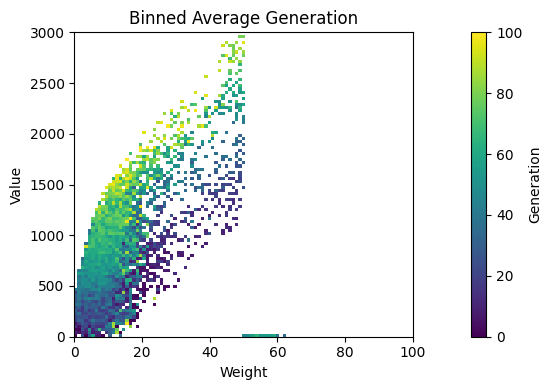

In [3]:
from scipy.stats import binned_statistic_2d

y = final_population_results["Value"]
x = final_population_results["Weight"]
c = final_population_results["Generation"]

x_bins = np.linspace(0, 100, 100)
y_bins = np.linspace(0, 3000, 100)

ret = binned_statistic_2d(x, y, c, statistic=np.mean, bins=[x_bins, y_bins])

fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))

im = ax1.imshow(ret.statistic.T, origin='lower', extent=(0,100,0,3000), vmin=0, vmax=100, aspect=.03)
ax1.set_xlabel("Weight")
ax1.set_ylabel("Value")
ax1.set_title("Binned Average Generation")

cbar = fig.colorbar(im,)
cbar.set_label('Generation')
plt.tight_layout()